In [67]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob


captureSize = 35.8 #for tmb claculation

VC_NONSYNONYMOUS_LIST = ['Frame_Shift_Del',
                         'Frame_Shift_Ins',
                         'In_Frame_Del',
                         'In_Frame_Ins',
                         'Missense_Mutation',
                         'Nonsense_Mutation',
                         'Splice_Site',
                         'Nonstop_Mutation',
                         'Splice_Region']

truncate_mut_LIST = ['Nonsense_Mutation', 'Frame_Shift_Ins','Frame_Shift_Del','Splice_Site']
nontruncate_mut_LIST = ['Missense_Mutation','In_Frame_Del', 'In_Frame_Ins','Nonstop_Mutation']

In [68]:
tcga_data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/TCGA/GDC_v37'

In [69]:
tpms = glob(os.path.join(tcga_data_path, '*', 'rnaSeq_tpm_matrix.csv'))
samples = glob(os.path.join(tcga_data_path, '*', 'rnaSeq_sample_table.txt'))
genes = glob(os.path.join(tcga_data_path, '*', 'rnaSeq_gene_table.txt'))
scnvs = glob(os.path.join(tcga_data_path, '*', 'SCNV_table.txt'))
snvs = glob(os.path.join(tcga_data_path, '*', 'SNV_table.txt'))
drugs = glob(os.path.join(tcga_data_path, '*', 'clinical_drug_table.txt'))
patients = glob(os.path.join(tcga_data_path, '*', 'clinical_patient_table.txt'))
proteins = glob(os.path.join(tcga_data_path, '*', 'proteome_table.txt'))

In [70]:
len(tpms),len(samples),len(genes),len(scnvs),len(snvs),len(drugs),len(patients),len(proteins)

(33, 33, 33, 33, 33, 33, 33, 32)

### SCNA burden calculation

[Jin.SCNA](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8505672/)defined as the sum of the log2-transformed copy-number ratio (tumor vs. normal) of genomic segments normalized by segment length.

In [71]:
scnv_tbs = []
for cnv in scnvs:
    cancer_type = os.path.basename(os.path.dirname(cnv))
    dfc = pd.read_csv(cnv,sep='\t')
    scnv_sum = dfc.groupby('Sample')['Segment_Mean'].sum().to_frame(name='scnv_jin_sum')
    scnv_mean = dfc.groupby('Sample')['Segment_Mean'].mean().to_frame(name='scnv_jin_mean')
    scnv = scnv_sum.join(scnv_mean)
    scnv_tbs.append(scnv)

In [72]:
df_scnv = pd.concat(scnv_tbs)
df_scnv.index.name = 'bcr_patient_barcode'
df_scnv.head(3)

,scnv_jin_sum,scnv_jin_mean
bcr_patient_barcode,,
TCGA-2W-A8YY,-22.537,-0.121822
TCGA-4J-AA1J,-10.312,-0.019755
TCGA-BI-A0VR,-32.871,-0.177681


### Tumor mutaion burden (TMB) calculation

In [73]:
tmb_tbs = []
for snv in snvs:
    cancer_type = os.path.basename(os.path.dirname(snv))
    mut = pd.read_csv(snv,sep='\t')
    mut['nansynonymous_mut_flag'] = mut.Variant_Classification.isin(VC_NONSYNONYMOUS_LIST)
    mut['truncate_mut_flag'] = mut.Variant_Classification.isin(truncate_mut_LIST)
    mut['nontruncate_mut_flag'] = mut.Variant_Classification.isin(nontruncate_mut_LIST)
    g = mut.groupby(['Tumor_Sample_Barcode'])
    tmb1 = g.nansynonymous_mut_flag.sum().to_frame(name = 'tmb_wang')
    tmb2 = g.apply(lambda x:x.truncate_mut_flag.sum()*2+x.nontruncate_mut_flag.sum()).to_frame(name = 'tmb_dan')

    truncate_mut = g.truncate_mut_flag.sum().to_frame(name = 'truncate_mut')
    nontruncate_mut = g.nontruncate_mut_flag.sum().to_frame(name = 'nontruncate_mut')
    
    tmb = tmb1.join(tmb2).join(truncate_mut).join(nontruncate_mut)
    tmb['cancer_type'] = cancer_type
    tmb_tbs.append(tmb)

/home/was966/anaconda3/envs/aggmap/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (75,113,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/was966/anaconda3/envs/aggmap/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/was966/anaconda3/envs/aggmap/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (75,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/was966/anaconda3/envs/aggmap/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (75,79,113,115,121,133) have mixed types.Specify dtype option on import or set low_memory

In [74]:
df_tmb = pd.concat(tmb_tbs, axis=0)
df_tmb = df_tmb.reset_index()
## pateint barcode: https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
df_tmb.columns = ['bcr_patient_barcode', 'tmb_wang', 'tmb_dan', 'truncate_mut','nontruncate_mut','cancer_type']
df_tmb = df_tmb[['bcr_patient_barcode', 'cancer_type', 'tmb_wang', 'tmb_dan', 'truncate_mut','nontruncate_mut']]
df_tmb = df_tmb.set_index('bcr_patient_barcode')

df_tmb = df_tmb[(df_tmb.tmb_wang != 0) & (df_tmb.tmb_dan != 0)]
df_tmb.tmb_wang = np.log2(df_tmb.tmb_wang/captureSize)
df_tmb.tmb_dan = np.log2(df_tmb.tmb_dan/captureSize)

### MSI table

MSI_H: msiscore >= 10%, MSI_L: 3.5% =< msiscore < 10%; MSS: msiscore < 3.5%

https://github.com/niu-lab/msisensor2/issues/3

In [75]:
df_msi = pd.read_csv(os.path.join(tcga_data_path, 'SMI_table.txt'), sep='\t', index_col=0)
df_msi.index.name = 'bcr_patient_barcode'

df1 = df_msi[df_msi['MSIsensor.score'] >= 10/100]
df1['msi_status'] = 'MSI-H'

df2 = df_msi[(df_msi['MSIsensor.score'] >= 3.5/100) & (df_msi['MSIsensor.score'] < 10/100)]
df2['msi_status'] = 'MSI-L'

df3 = df_msi[df_msi['MSIsensor.score'] < 3.5/100]
df3['msi_status'] = 'MSS'

df_m = df1.append(df2).append(df3)

df_msi = pd.get_dummies(df_m.msi_status)
df_msi['MSIsensorScore'] = df_m['MSIsensor.score']

/tmp/ipykernel_2483/2352729601.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['msi_status'] = 'MSI-H'
/tmp/ipykernel_2483/2352729601.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['msi_status'] = 'MSI-L'
/tmp/ipykernel_2483/2352729601.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [76]:
df1.shape,df2.shape,df3.shape

((4580, 3), (1591, 3), (4612, 3))

### sample overlaps

In [77]:
coset = set(df_scnv.index) & set(df_tmb.index) & set(df_msi.index) 

In [78]:
df_mut = pd.DataFrame(index=coset).join(df_tmb).join(df_msi).join(df_scnv)
df_mut_log2 = np.log2(df_mut[['tmb_wang', 'tmb_dan', 'MSI-H', 'MSI-L', 'MSS', 'MSIsensorScore', 'truncate_mut', 'nontruncate_mut']] + 1)

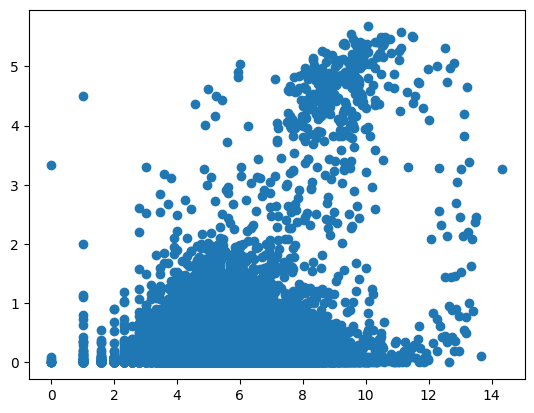

In [79]:
plt.scatter(df_mut_log2.nontruncate_mut, df_mut_log2.MSIsensorScore)

In [80]:
df_mut.to_pickle(os.path.join(tcga_data_path, 'df_patient_mut.pkl'))